In [114]:
import autograd.numpy as np
from autograd import elementwise_grad
import numpy.linalg as la
from scipy.sparse import spdiags

import matplotlib.pyplot as plt
colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

In [134]:
# Parameters
eta = 6.0
gamma = 1.0

t_max = 2
c = 1.4 # the speed and two times the height of the wave
P = 20  # period
M = 100  # number of spatial points
N = 100 # number of temporal points

In [135]:
# Utility functions
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy

# Simple analytic Soliton

In [136]:
x, dx = grid(P, M)
u_soliton = lambda x, t: 1/2*c*sech(np.abs((x-c*t) % P - P/2))**2

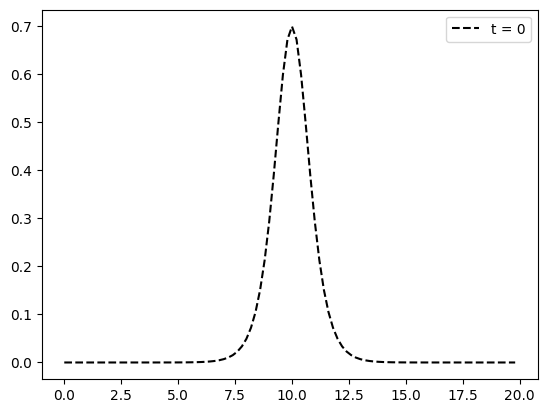

In [137]:
plt.plot(x, u_soliton(x, 0), 'k--', label='t = 0'); plt.legend();

# Non-analytic Solitons

In [8]:

g = lambda x, t: 0
f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) + g(x, t)
Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)


In [9]:
# Utility functions
def difference_matrices(P=20, M=100):
    dx = P/M
    e = np.ones(M) # unit vector of length M
    # 1st order central difference matrix:
    D1 = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray()
    # 2nd order central difference matrix:
    D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], np.array([-M+1,-1,0,1,M-1]), M, M).toarray()
    return D1, D2

def midpoint_method(u, un, t ,f ,Df ,dt ,M ,tol ,max_iter):
    '''
    Integrating one step of the ODE u_t = f, from u to un,
    with the implicit midpoint method
    Using Newton's method to find un
    '''
    I = np.eye(M)
    F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)/2, t+.5*dt)
    J = lambda u_hat: 1/dt*I - 1/2*Df((u+u_hat)/2)
    err = la.norm(F(un))
    it = 0
    while err > tol:
        un = un - la.solve(J(un),F(un))
        err = la.norm(F(un))
        it += 1
        if it > max_iter:
            break
    return un

In [10]:
def initial_condition_kdv(x=np.linspace(0,20.-.2,100), eta=6.):
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))
    k1, k2 = 1., .75
    d1, d2 = .25, .5
    sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
    u0 = 0
    u0 += (-6./-eta)*2 * k1**2 * sech(np.abs(k1 * ((x+P/2-P*d1) % P - P/2)))**2
    u0 += (-6./-eta)*2 * k2**2 * sech(np.abs(k2 * ((x+P/2-P*d2) % P - P/2)))**2
    u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0

In [141]:
# Parameters
eta = 6.0
gamma = 1.0

t_max = 2
c = 1.4 # the speed and two times the height of the wave
P = 20  # period
M = 100  # number of spatial points
N = 100 # number of temporal points

# Grids
x, dx = grid(P, M) # spatial grid
t, dt = grid(t_max, N) # temporal grid

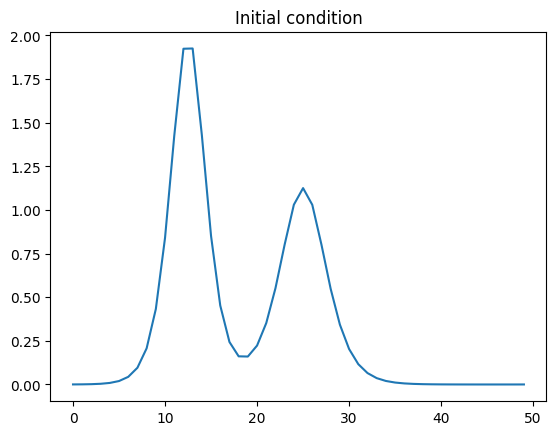

In [14]:
D1, D2 = difference_matrices(P,M)
u0 = initial_condition_kdv(x, eta)
plt.plot(u0); plt.title('Initial condition');

In [20]:
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
# The implicit midpoint method:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

39.8 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


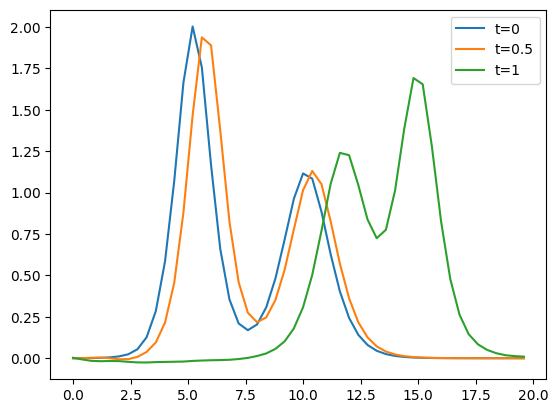

In [19]:
plt.plot(x, u[3,:], label='t=0'); plt.plot(x, u[10,:], label='t=0.5'); plt.plot(x, u[-1,:], label='t=1'); plt.legend();

# Hamiltonian energy conservation

Ht.shape: torch.Size([2, 100])
H0.shape: torch.Size([2, 1])


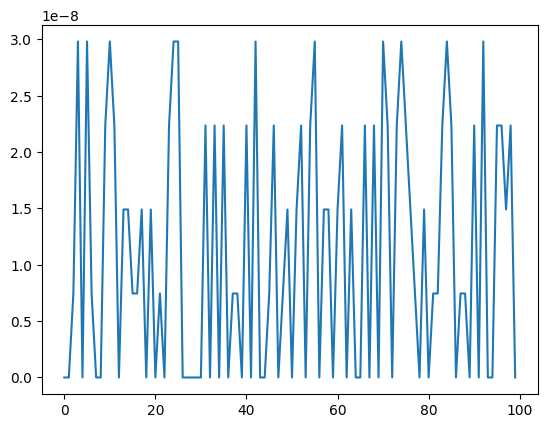

In [191]:
# The discrete Hamiltonian

def energy_conservation_2d(u, dx, eta, gamma):

    M = u.size(-1)
    device = u.device
    e = torch.ones(M, device=device, dtype=torch.float)
    Dp = .5 / dx * torch.sparse.spdiags(torch.stack([e, -e, e, -e]), torch.tensor([-M+1, -1, 1, M-1], device=device), (M, M)).to_dense()
    H = lambda u: dx*torch.sum(-1/6*eta*u**3 + (.5*gamma**2*torch.matmul(Dp,u.transpose(0, 1)).transpose(0, 1)**2), dim=1)
    Ht = H(u)
    return torch.abs(Ht - Ht[0])

import torch
def energy_conservation_tensor(u, dx, eta, gamma):
    """
    Returns the energy conservation error for the KdV equation
    u: solution tensor of shape (batch_size, time_steps, M)
    M: number of spatial points
    dx: spatial step size
    eta: model specific parameter
    gamma: model specific parameter
    :returns: energy conservation error tensor of shape (batch_size, time_steps) for each time step
    """
    M = u.size(-1)
    device = u.device
    e = torch.ones(M, device=device, dtype=torch.float)
    Dp = .5 / dx * torch.sparse.spdiags(torch.stack([e, -e, e, -e]), torch.tensor([-M+1, -1, 1, M-1], device=device), (M, M)).to_dense()
    H = lambda u: dx*torch.sum(-1/6*eta*u**3 + (.5*gamma**2*torch.matmul(Dp,u.transpose(1, 2)).transpose(1, 2)**2), dim=2)
    #H0 = H(u[:, :1, :])
    Ht = H(u)
    H0 = Ht[:, 0, None]
    print(f"Ht.shape: {Ht.shape}")
    print(f"H0.shape: {H0.shape}")
    return torch.abs(Ht - H0)

#u = torch.tensor(u, dtype=torch.float).detach()
errror = energy_conservation_tensor(torch.stack([u,u]), dx, eta, gamma)
plt.plot(errror[0,:])

0.2


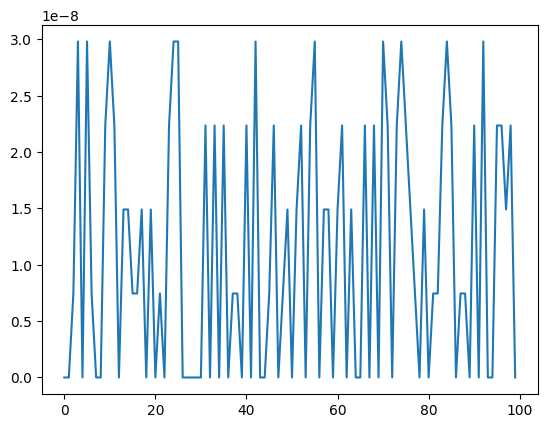

In [179]:
u0 = u_soliton(x, 0)
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = u_soliton(x, t_step)
print(dx)
errror = energy_conservation_tensor(torch.tensor(u[None,:,:], dtype=torch.float), dx, eta=6.0, gamma=1.0)
plt.plot(errror[0,:])

In [0]:
plt.plot(x, u[0]); plt.plot(x, u[10]); plt.plot(x, u[-1]);

In [154]:

H = energy_conservation_tensor(torch.tensor(u[None,:,:], dtype=torch.float), dx, eta=6.0, gamma=1.0)
H.size()

torch.Size([1, 100])

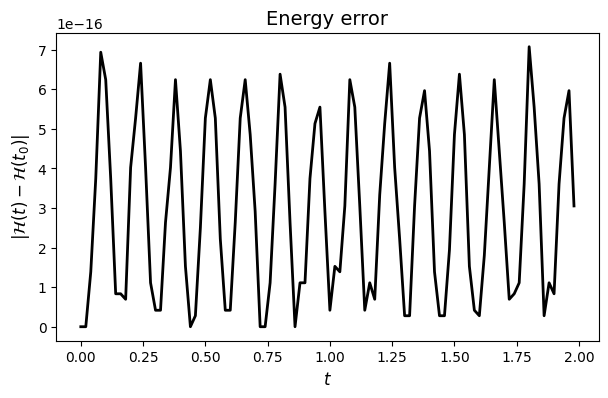

In [164]:
e = np.ones(M)
Dp = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray() # Foward difference matrix
# The discrete Hamiltonian
H = lambda u: dx*np.sum(-1/6*eta*u**3 + (.5*gamma**2*(np.matmul(Dp,u.T))**2).T, axis=1)

fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(t, np.abs(H(u)-H(u)[0]), 'k', linewidth=lw)
plt.xlabel('$t$', fontsize=12)
plt.ylabel('$|\mathcal{H}(t) - \mathcal{H}(t_0)|$', fontsize=12)
plt.title('Energy error', fontsize=14)
plt.show()

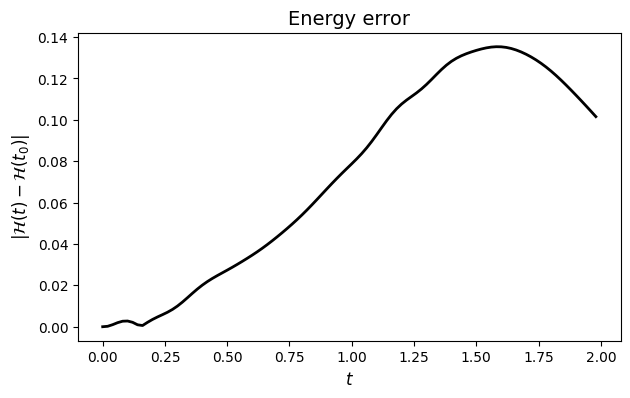

In [98]:
fig = plt.figure(figsize=(7,4))
lw = 2
H_0 = H(u[:1,:])
plt.plot(t, np.abs(H(u)-H_0), 'k', linewidth=lw)
plt.xlabel('$t$', fontsize=12)
plt.ylabel('$|\mathcal{H}(t) - \mathcal{H}(t_0)|$', fontsize=12)
plt.title('Energy error', fontsize=14)
plt.show()

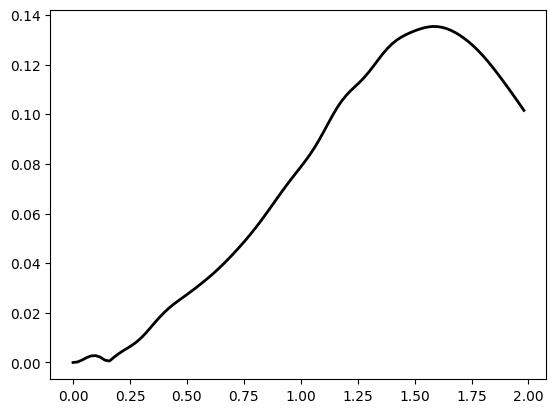

In [101]:
error2 = energy_conservation_tensor(torch.tensor(u[None,:,:], dtype=torch.float), M, dx, eta, gamma)
plt.plot(t, error2[0,:].numpy(), 'k', linewidth=lw)